In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install umap-learn[plot]
!pip install pyconll


In [ ]:
from statistics import linear_regression
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer


from sklearn.pipeline import Pipeline
import nltk
import umap
from nltk.help import upenn_tagset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, average_precision_score
import pandas as pd
import numpy as np
import time
import os
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import auc
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import wordnet,subjectivity,stopwords
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import re
import string
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

import torch # torch provides basic functions, from setting a random seed (for reproducability) to creating tensors.
import torch.nn as nn # torch.nn allows us to create a neural network.
import torch.nn.functional as F # nn.functional give us access to the activation and loss functions.
from torch.optim import Adam # optim contains many optimizers. Here, we're using SGD, stochastic gradient descent, specifically Adam.
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

nltk.download("subjectivity")
nltk.download('tagsets_json')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Package tagsets_json is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_ta

True

# Ex.10 Word Embeddings MLP for POS Tagging

In [ ]:
import os
file_path_dev = "en_gum-ud-dev.conllu"
file_path_train = "en_gum-ud-train.conllu"
file_path_test = "en_gum-ud-test.conllu"
print(os.getcwd())

/content


In [ ]:
import pyconll
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences
data_dev = read_conllu(file_path_dev)
data_train = read_conllu(file_path_train)
data_test = read_conllu(file_path_test)

print(len(data_dev))
print(len(data_train))
print(len(data_test))
print(data_dev[0],data_train[0],data_test[0])

1341
9520
1285
[('introduction', 'NOUN')] [('aesthetic', 'ADJ'), ('appreciation', 'NOUN'), ('and', 'CCONJ'), ('spanish', 'ADJ'), ('art', 'NOUN'), (':', 'PUNCT')] [('the', 'DET'), ('prevalence', 'NOUN'), ('of', 'ADP'), ('discrimination', 'NOUN'), ('across', 'ADP'), ('racial', 'ADJ'), ('groups', 'NOUN'), ('in', 'ADP'), ('contemporary', 'ADJ'), ('america', 'PROPN'), (':', 'PUNCT')]


In [ ]:
def load_ud_treebank_data(sentences):
    # Sample format: (word, pos_tag)

    words = []
    pos_tags = []

    for sentence in sentences:
        for word, pos in sentence:
            words.append(word)
            pos_tags.append(pos)

    return words, pos_tags

In [ ]:
X_dev,Y_dev = load_ud_treebank_data(data_dev)
X_train,Y_train = load_ud_treebank_data(data_train)
X_test,Y_test = load_ud_treebank_data(data_test)

print(X_dev[0],Y_dev[0])
print(X_train[0],Y_train[0])
print(X_test[0],Y_test[0])

print(set(Y_train + Y_dev + Y_test))

introduction NOUN
aesthetic ADJ
the DET
{'PART', 'PRON', 'ADJ', 'X', 'VERB', 'ADP', 'ADV', 'INTJ', 'PUNCT', 'SCONJ', 'NOUN', 'DET', 'AUX', 'PROPN', 'CCONJ', 'SYM', 'NUM'}


In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [ ]:
print(wv)

KeyedVectors<vector_size=300, 3000000 keys>


In [ ]:
def plot_training_histories(histories):
    # Plotting loss
    colors = [
        ("lightgreen","green"),
        ("lightblue","blue")
    ]
    plt.figure()
    for (index,history) in enumerate(histories):
      plt.plot(history['train_loss'], label=f'Training Loss {index}',color=colors[index][0])
      plt.plot(history['val_loss'], label=f'Validation Loss {index}',color=colors[index][1])

    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    for (index,history) in enumerate(histories):

        plt.plot(history['train_accuracy'], label=f'Training Accuracy {index}',color=colors[index][0])
        plt.plot(history['val_accuracy'], label=f'Validation Accuracy {index}',color=colors[index][1])
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    for (index,history) in enumerate(histories):
        plt.plot(history['train_f1_score'], label=f'Training Accuracy {index}',color=colors[index][0])
        plt.plot(history['val_f1_score'], label=f'Validation Accuracy {index}',color=colors[index][1])
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def text_word_embedding(token, model):
    try:
        return np.asarray(model[token.lower()])
    except:
        #return np.asarray(np.zeros((300,1)))
        pass



x_train_word_embeddings = [text_word_embedding(token,wv) for token in X_train]
x_train_word_embeddings = [var_word_embedding if var_word_embedding is not None else np.full((300,), 0.42) for var_word_embedding in x_train_word_embeddings]

print("the type of x_train_word_embeddings is:", type(x_train_word_embeddings))
print("x_train_word_embeddings length is:", len(x_train_word_embeddings))
print("the size of an word embedding is: ", x_train_word_embeddings[0].shape)
x_train_word_embeddings = np.stack(x_train_word_embeddings, axis=0)
print("x_train_word_embeddings length is:", len(x_train_word_embeddings))

x_dev_word_embeddings = [text_word_embedding(token,wv) for token in X_dev]
x_dev_word_embeddings = [var_word_embedding if var_word_embedding is not None else np.full((300,), 0.42) for var_word_embedding in x_dev_word_embeddings]
print("the type of x_dev_word_embeddings is:", type(x_dev_word_embeddings))
print("x_dev_word_embeddings length is:", len(x_dev_word_embeddings))
print("the size of an word embedding is: ", x_dev_word_embeddings[0].shape)
x_dev_word_embeddings = np.stack(x_dev_word_embeddings, axis=0)

x_test_word_embeddings = [text_word_embedding(token,wv) for token in X_test]
x_test_word_embeddings = [var_word_embedding if var_word_embedding is not None else np.full((300,), 0.42) for var_word_embedding in x_test_word_embeddings]
print("the type of x_test_word_embeddings is:", type(x_test_word_embeddings))
print("x_test_word_embeddings length is:", len(x_test_word_embeddings))
print("the size of an word embedding is: ", x_test_word_embeddings[0].shape)
x_test_word_embeddings = np.stack(x_test_word_embeddings, axis=0)

the type of x_train_word_embeddings is: <class 'list'>
x_train_word_embeddings length is: 164108
the size of an word embedding is:  (300,)
x_train_word_embeddings length is: 164108
the type of x_dev_word_embeddings is: <class 'list'>
x_dev_word_embeddings length is: 23920
the size of an word embedding is:  (300,)
the type of x_test_word_embeddings is: <class 'list'>
x_test_word_embeddings length is: 24005
the size of an word embedding is:  (300,)


In [ ]:
class MLP_centroids(nn.Module):
    def __init__(self):
        super(MLP_centroids, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(300, 256), # Dense layer. Takes the input of shape (batch_size, 300) and connects it to 1024 nodes (batch_size, 1024)
            nn.ReLU(), # Applies ReLU activation function
            nn.Dropout(0.3), # Applies 30% dropout
            nn.Linear(256, 256), # Dense layer. Connects the 1024 nodes with 1024 nodes. (batch_size, 1024)
            nn.ReLU(), # Applies ReLU activation function
            nn.Dropout(0.3), # Applies 30% dropout
            nn.Linear(256, 128), # Dense layer. Takes the 1024 nodes and connects them to 512. (batch_size, 512)
            nn.ReLU(), # Applies ReLU activation function
            nn.Dropout(0.4), # Applies 30% Dropout
            nn.Linear(128, 17) # Final dense layer. Produces the so called "logits" which are the results after the dense layer before the softmax.
        )

    def forward(self, input):
        return self.network(input) # Forward pass of the input through the neural network

mlp_cent = MLP_centroids()
print(mlp_cent)

MLP_centroids(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=128, out_features=17, bias=True)
  )
)


In [ ]:

labels = list(set(Y_train + Y_dev + Y_test))
print(labels,len(labels))
labels_dict = {}
for x,y in enumerate(labels):
    labels_dict[y] = x
print(labels_dict)
Y_train = list(map(lambda x: labels_dict[x],Y_train))
Y_dev = list(map(lambda x: labels_dict[x],Y_dev))
Y_test = list(map(lambda x: labels_dict[x],Y_test))
print(Y_train[:3],Y_dev[:3],Y_test[:3])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] 17
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16}
[2, 10, 14] [10, 10, 5] [11, 10, 5]


In [ ]:
print(x_train_word_embeddings[0][0])

X_train_cent_tensor = torch.tensor(x_train_word_embeddings, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_dev_cent_tensor = torch.tensor(x_dev_word_embeddings, dtype=torch.float32)
y_dev_tensor = torch.tensor(Y_dev, dtype=torch.long)

X_test_cent_tensor = torch.tensor(x_test_word_embeddings, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)


0.045166015625


In [ ]:
batch_size = 256

print(X_train_cent_tensor.shape)
print(y_train_tensor.shape)

train_dataset = TensorDataset(X_train_cent_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dev_dataset = TensorDataset(X_dev_cent_tensor, y_dev_tensor)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_cent_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([164108, 300])
torch.Size([164108])


In [ ]:
def train_mlp_with_params():
    global train_loader,dev_loader,test_loader
    model_mlp_tf_idf = MLP_centroids() # Instantiate the model. If your model had variable arguments, you would have to set their value here
    model_mlp_tf_idf.to(torch.device('cpu'))
    optimizer = Adam(model_mlp_tf_idf.parameters(), lr = 0.001) # Define the optimizer you wish to use, in this case Adam
    criterion = nn.CrossEntropyLoss() # Define the loss function specific to your problem.
                                  # Check pytorch documentation for more details. Different loss functions are used for different problems
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1_score': [], 'val_f1_score': []}
    epochs = 150
## 250 epochs are too much in our scenario, the loss gets too low
## 150 seems good for us
## this is the optimization loop. Each time the optimizer sees all of the training data is called an "epoch".

    best_val_loss = float("inf") # Initialize to a high value to track the lowest validation loss
    best_model_path = None  # To keep track of the previous best model file


    for epoch in range(epochs):
        model_mlp_tf_idf.train()  # Set the model to training mode
        running_loss = 0.0  # Track the loss for the epoch
        train_outputs = [] # the list which contains the outputs of a batch
        train_labels = [] # the list which contains the labels of a batch

    ## this internal loop is where the optimizer sees all of the training data and where we
    ## calculate the total_loss for all of the training data.
        for batch in train_loader:

            features, labels = batch
            features = features.to(torch.device('cpu')) # Move features to device
            labels = labels.to(torch.device('cpu')) # Move labels to device

            optimizer.zero_grad()  # Zero the gradients

        # Forward pass: Computes the model output
            outputs = model_mlp_tf_idf(features)

        # Calculate the loss with class indices (not one-hot)
            loss = criterion(outputs, labels)  # labels should be class indices, not one-hot
            loss.backward()  # Backward pass

            optimizer.step()  # Optimize (Update the model parameters)

        # Accumulate the loss
            running_loss += loss.item()

        # the outputs from forward pass
            train_outputs.append(outputs)
            train_labels.append(labels)

        #----------------------------------------------------------------------------------------------------------------

    # Concatenate all outputs and labels
        train_outputs = torch.cat(train_outputs)
        train_labels = torch.cat(train_labels)

    # (1) Get label indices
    ####################################################
    #train_classes = torch.argmax(train_labels, dim = 1)
    ####################################################
        train_classes = train_labels

    # (2) Get predicted class indices (we want ro transform the vector to one-hot
    #     (we put one in the index of max element and zeros to others))
        train_predicted_classes = torch.argmax(train_outputs, dim=1)

    # Print average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        # print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {epoch_loss:.4f}')

    #mexri 0.003 kati

        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(train_classes.cpu(), train_predicted_classes.cpu())
        train_f1_score = f1_score(train_classes.cpu(), train_predicted_classes.cpu(), average='weighted')
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1_score'].append(train_f1_score)

    ############################################################################

    # Validation phase
    # Set the model to evaluation mode
        model_mlp_tf_idf.eval()
        val_running_loss = 0.0
        all_outputs = []
        all_labels = []

    # We want to not update the gradients when it is updating the weights
        with torch.no_grad():
            for features, labels in dev_loader:
                features = features.to(torch.device('cpu'))
                labels = labels.to(torch.device('cpu'))
                outputs = model_mlp_tf_idf(features)
            # We compute the validation loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                all_outputs.append(outputs)
                all_labels.append(labels)

        # Concatenate all outputs and labels
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)

        # Get label indices
        #true_classes = torch.argmax(all_labels, dim=1)
        true_classes = all_labels

        # Get predicted class indices
        predicted_classes = torch.argmax(all_outputs, dim=1)

        # Calculate metrics on the entire validation set
        val_accuracy = accuracy_score(true_classes.cpu(), predicted_classes.cpu())
        val_f1 = f1_score(true_classes.cpu(), predicted_classes.cpu(), average='weighted')

        # Append to history
        val_loss = val_running_loss / len(dev_loader)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1_score'].append(val_f1)

        # Print validation metrics
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        # Save checkpoint at the lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'

            # Delete the previous best model if it exists
            if best_model_path is not None:
                os.remove(best_model_path)

            # Save the new best model
            torch.save(model_mlp_tf_idf.state_dict(), new_model_path)
            best_model_path = new_model_path  # Update the best model path
            #print(f"Checkpoint saved at epoch {epoch+1} with F1: {val_f1:.4f}")
    return model_mlp_tf_idf,history,best_model_path

In [ ]:
model_mlp_tf_idf,history,best_model_path = train_mlp_with_params()


Validation Loss: 0.684744970595583
Validation Accuracy: 0.7935, F1 Score: 0.7867
Validation Loss: 0.6552311958784752
Validation Accuracy: 0.7965, F1 Score: 0.7906
Validation Loss: 0.6462914994422425
Validation Accuracy: 0.7994, F1 Score: 0.7937
Validation Loss: 0.6418549630870211
Validation Accuracy: 0.8009, F1 Score: 0.7960
Validation Loss: 0.6428741362500698
Validation Accuracy: 0.7980, F1 Score: 0.7924
Validation Loss: 0.6375088707563725
Validation Accuracy: 0.8019, F1 Score: 0.7964
Validation Loss: 0.637741133887717
Validation Accuracy: 0.8022, F1 Score: 0.7973
Validation Loss: 0.6344966013380822
Validation Accuracy: 0.8012, F1 Score: 0.7957
Validation Loss: 0.633263904680597
Validation Accuracy: 0.8019, F1 Score: 0.7962
Validation Loss: 0.6375939658981689
Validation Accuracy: 0.7999, F1 Score: 0.7940
Validation Loss: 0.6399796367325681
Validation Accuracy: 0.7997, F1 Score: 0.7937
Validation Loss: 0.6449334726054617
Validation Accuracy: 0.7995, F1 Score: 0.7943
Validation Loss: 0.

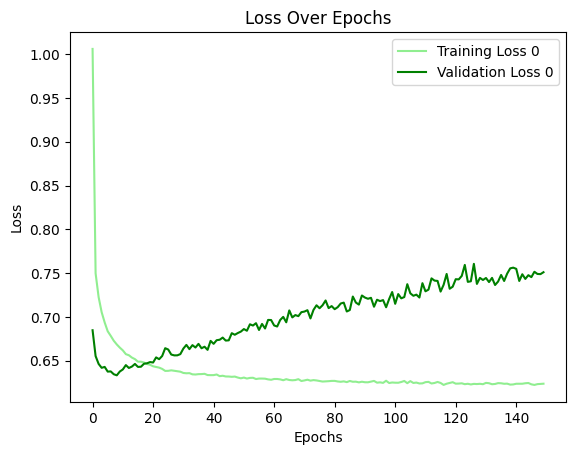

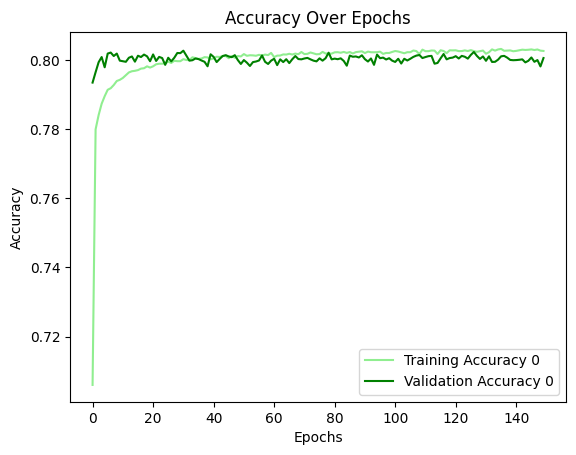

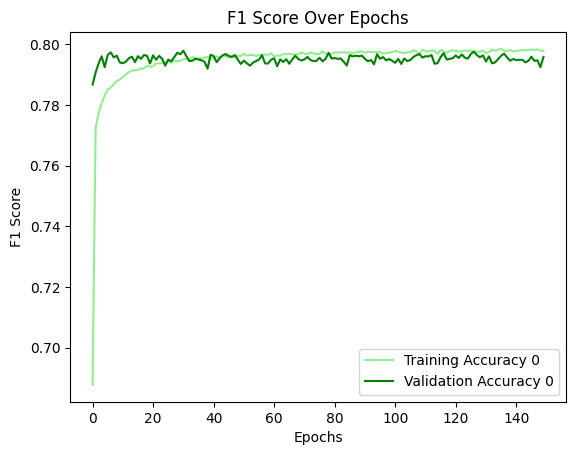

In [ ]:
plot_training_histories([history])

In [ ]:
model_mlp_tf_idf.eval()
model_mlp_tf_idf.to("cpu")

pred_val = model_mlp_tf_idf(X_dev_cent_tensor)

y_pred_val = torch.argmax(pred_val, dim=1)
categories = ['PART', 'PRON', 'ADJ', 'X', 'VERB', 'ADP', 'ADV', 'INTJ', 'PUNCT', 'SCONJ', 'NOUN', 'DET', 'AUX', 'PROPN', 'CCONJ', 'SYM', 'NUM']
print(model_mlp_tf_idf)
print(f"Results in Validation Data for MLP with TFIDF Features, trained for 150 epochs")
print(classification_report(y_dev_tensor, y_pred_val, target_names=categories))

print(f'MLP TF-IDF Validation Accuracy: {accuracy_score(y_dev_tensor, y_pred_val)*100:.2f}%')

predictions_test = model_mlp_tf_idf(X_test_cent_tensor)
y_pred_test = torch.argmax(predictions_test, dim=1)
print(f'MLP TF-IDF Test Accuracy:{accuracy_score(y_test_tensor, y_pred_test)*100:.2f}%')

X_train_cent_tensor = torch.tensor(x_train_word_embeddings, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_dev_cent_tensor = torch.tensor(x_dev_word_embeddings, dtype=torch.float32)
y_dev_tensor = torch.tensor(Y_dev, dtype=torch.long)

X_test_cent_tensor = torch.tensor(x_test_word_embeddings, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

MLP_centroids(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=128, out_features=17, bias=True)
  )
)
Results in Validation Data for MLP with TFIDF Features, trained for 150 epochs
              precision    recall  f1-score   support

        PART       1.00      0.30      0.46       661
        PRON       0.92      0.96      0.94      2279
         ADJ       0.88      0.90      0.89      1584
           X       0.75      0.25      0.38        12
        VERB       0.90      0.85      0.88      2676
         ADP       0.86      0.64      0.73      2226
         ADV       0.91      0.79      0.84      1150
        INTJ       0.84      0

ValueError: too many dimensions 'str'